In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/1_code/')
from func import set_proj_env, rank_int, node_strength

In [3]:
parc_str = 'schaefer'
parc_scale = 200
edge_weight = 'streamlineCount'
set_proj_env()

('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/0_data',
 '/Volumes/work_ssd/research_data/PNC/',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output')

In [4]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_200_streamlineCount_'

In [5]:
# Parcellation specifications
if parc_str == 'schaefer':
    # Names of parcels
    parcel_names = np.genfromtxt(os.path.join(os.environ['PROJDIR'], 'figs_support/labels/schaefer' + str(parc_scale) + 'NodeNames.txt'), dtype='str')
    num_parcels = parcel_names.shape[0]
    
    scdir = os.path.join(os.environ['DERIVSDIR'], 'processedData/diffusion/deterministic_20171118'); os.environ['SCDIR'] = scdir
    sc_name_tmp = 'bblid/*xscanid/tractography/connectivity/bblid_*xscanid_SchaeferPNC_' + str(parc_scale) + '_dti_' + edge_weight + '_connectivity.mat'

    rstsdir = os.path.join(os.environ['DERIVSDIR'], 'processedData/restbold/restbold_201607151621')
    if parc_scale == 200:
        rsts_name_tmp = 'bblid/*xscanid/net/Schaefer' + str(parc_scale) + 'PNC/bblid_*xscanid_Schaefer' + str(parc_scale) + 'PNC_ts.1D'
    elif parc_scale == 400:
        rsts_name_tmp = 'bblid/*xscanid/net/SchaeferPNC/bblid_*xscanid_SchaeferPNC_ts.1D'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline


In [7]:
storedir = os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'store')
print(storedir)
if not os.path.exists(storedir): os.makedirs(storedir)

outputdir = os.path.join(os.environ['PIPELINEDIR'], '1_compute_node_features', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline/1_compute_node_features/store
/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline/1_compute_node_features/out


In [8]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output/figs


## Load data

In [9]:
# Load data
df = pd.read_csv(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', 'df.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1100, 58)


In [10]:
# Missing data file for this subject only for schaefer 200
if parc_scale == 200:
    df.drop(labels = (112598, 5161), inplace=True)

In [11]:
# output dataframe
str_labels = ['str_' + str(i) for i in range(num_parcels)]

df_node = pd.DataFrame(index = df.index, columns = str_labels)
print(df_node.shape)

(1099, 200)


## Load in structural connectivity matrices

In [12]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [13]:
A = np.zeros((num_parcels, num_parcels, df.shape[0]))
for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = sc_name_tmp.replace("scanid", str(index[1]))
    file_name = file_name.replace("bblid", str(index[0]))
    full_path = glob.glob(os.path.join(scdir, file_name))
    if i == 0: print(full_path)
    if len(full_path) > 0:
        mat_contents = sio.loadmat(full_path[0])
        a = mat_contents['connectivity']
        if parc_str == 'lausanne' and parc_variant == 'cortex_only':
            a = a[parcel_loc == 1,:]
            a = a[:,parcel_loc == 1]
        A[:,:,i] = a
    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        A[:,:,i] = np.full((num_parcels, num_parcels), np.nan)

['/Volumes/work_ssd/research_data/PNC/processedData/diffusion/deterministic_20171118/81287/20100114x2738/tractography/connectivity/81287_20100114x2738_SchaeferPNC_200_dti_streamlineCount_connectivity.mat']
82051/*x2856/tractography/connectivity/82051_*x2856_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87804/*x3144/tractography/connectivity/87804_*x3144_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
91332/*x3362/tractography/connectivity/91332_*x3362_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87990/*x3676/tractography/connectivity/87990_*x3676_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
103737/*x3964/tractography/connectivity/103737_*x3964_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
87470/*x4000/tractography/connectivity/87470_*x4000_SchaeferPNC_200_dti_streamlineCount_connectivity.mat: NOT FOUND
104161/*x4104/tractography/connectivity/104161_*x4104_SchaeferPNC_200_dti_streamlineCount_connec

In [14]:
np.sum(subj_filt)

19

In [15]:
if any(subj_filt):
    A = A[:,:,~subj_filt]
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]
print(df_node.shape)

(1080, 200)


### Check if any subjects have disconnected nodes in A matrix

In [16]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [17]:
for i in range(A.shape[2]):
    if np.any(np.sum(A[:,:,i], axis = 1) == 0):
        subj_filt[i] = True

In [18]:
np.sum(subj_filt)

12

In [19]:
if any(subj_filt):
    A = A[:,:,~subj_filt]
    df = df.loc[~subj_filt]
    df_node = df_node.loc[~subj_filt]
print(df_node.shape)

(1068, 200)


In [20]:
np.sum(df['averageManualRating'] == 2)

924

In [21]:
np.sum(df['dti64QAManualScore'] == 2)

655

### Get streamline count and network density

In [22]:
A_c = np.zeros((A.shape[2],))
A_d = np.zeros((A.shape[2],))
for i in range(A.shape[2]):
    A_c[i] = np.sum(np.triu(A[:,:,i]))
    A_d[i] = np.count_nonzero(np.triu(A[:,:,i]))/((A[:,:,i].shape[0]**2-A[:,:,i].shape[0])/2)
df.loc[:,'streamline_count'] = A_c
df.loc[:,'network_density'] = A_d

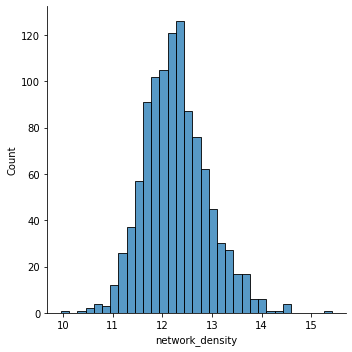

In [23]:
sns.displot(df.loc[:,'network_density']*100)

### Compute node metrics

In [24]:
# fc stored as 3d matrix, subjects of 3rd dim
S = np.zeros((df.shape[0], num_parcels))

for i in tqdm(np.arange(0,df.shape[0])):
    S[i,:] = node_strength(A[:,:,i])

df_node.loc[:,str_labels] = S

100%|██████████| 1068/1068 [00:00<00:00, 24781.98it/s]


# Save out

In [25]:
print(df_node.isna().any().any())

False


In [26]:
df.to_csv(os.path.join(storedir, outfile_prefix+'df.csv'))
np.save(os.path.join(storedir, outfile_prefix+'A'), A)
df_node.to_csv(os.path.join(outputdir, outfile_prefix+'df_node.csv'))